# SPAM Bert Classifier 
#### We fine tune a small BERT model for classification. First, download 'bert-base-uncased' from Hugging Face using the Transformers library. We compare how fine tuning everything does vs fine tuning just the MLP head. 


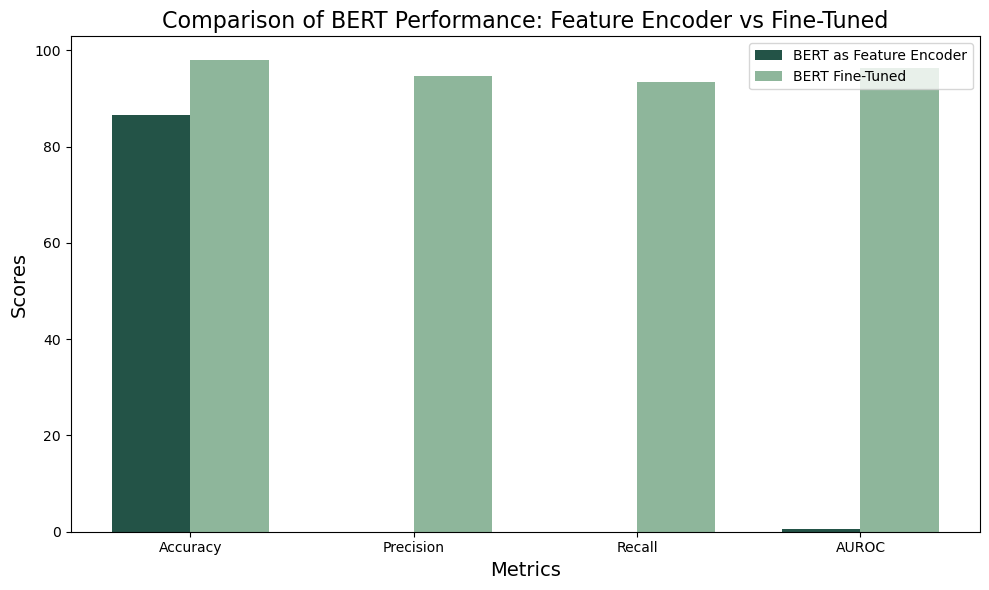

In [6]:
import matplotlib.pyplot as plt

# Data for creating the chart
metrics = ['Accuracy', 'Precision', 'Recall', 'AUROC']
bert_feature_encoder = [86.56, 0.0, 0.0, 0.5]
bert_fine_tuned = [98, 94.59, 93.43, 96.25]

# Setting up the figure size and plot
plt.figure(figsize=(10, 6))

# Creating bar plots for both models with specified colors
bar_width = 0.35
index = range(len(metrics))

plt.bar(index, bert_feature_encoder, bar_width, color='#235347', label='BERT as Feature Encoder')
plt.bar([p + bar_width for p in index], bert_fine_tuned, bar_width, color='#8EB69B', label='BERT Fine-Tuned')

# Adding titles and labels
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.title('Comparison of BERT Performance: Feature Encoder vs Fine-Tuned', fontsize=16)
plt.xticks([p + bar_width / 2 for p in index], metrics)

# Adding a legend
plt.legend()

# Display the plot
plt.tight_layout()
#plt.show()


plt.savefig('performance_comparison.png')

In [ ]:
!pip install torchmetrics

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

from tabulate import tabulate
from tqdm import trange
import random
from torchmetrics.classification import Recall, Accuracy, AUROC, Precision

In [ ]:
# You can do this or just add the zip file I give you
!wget 'https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
!unzip -o smsspamcollection.zip

--2023-12-09 10:11:05--  https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘smsspamcollection.zip’

smsspamcollection.z     [   <=>              ] 198.65K   308KB/s    in 0.6s    

2023-12-09 10:11:07 (308 KB/s) - ‘smsspamcollection.zip’ saved [203415]

Archive:  smsspamcollection.zip
  inflating: SMSSpamCollection       
  inflating: readme                  


In [ ]:
!head -10 SMSSpamCollection

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
ham	Ok lar... Joking wif u oni...
spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
ham	U dun say so early hor... U c already then say...
ham	Nah I don't think he goes to usf, he lives around here though
spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv
ham	Even my brother is not like to speak with me. They treat me like aids patent.
ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
spam	WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
spam	H

In [ ]:
# Loop through the data and make a dataframe with two columns
# Loading the dataset
df = pd.read_csv('SMSSpamCollection', sep='\t', names=['label', 'text'])
# Converting label to numerical
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# label is 0/1 if Not Spam / Spam
FILL_IN = "FILL_IN"

In [ ]:
text = df.text.values
labels = df.label.values

In [ ]:
# Get the tokenizer for BERT, using 'bert-based-uncased'
# Set do_lower_case = True
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
def print_rand_sentence():
    '''Displays the tokens and respective IDs of a random text sample'''
    index = random.randint(0, len(text)-1)
    # Tokenize a random sentence's text and display the token / token id
    # You might need to use "tabulate" on a certain numpy array
    index = random.randint(0, len(text) - 1)
    tokens = tokenizer.tokenize(text[index])
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    print(tabulate([tokens, token_ids], headers=['Tokens', 'Token IDs']))


print_rand_sentence()

                                                                                                                                                Tokens    Token IDs
----  ----  ----  -----  ----  ----  ----  ----  ----  ----  -----  ----  ----  -----  -----  ----  -----  ----  ----  ----  ----  -----  ----  --------  -----------
u     eat   ##in  later  but   i     '     m     eat   ##in  wi     ##f   my    fr     ##ens  now   lei    .     .     .     u     going  home  first     ?
1057  4521  2378  2101   2021  1045  1005  1049  4521  2378  15536  2546  2026  10424  6132   2085  26947  1012  1012  1012  1057  2183   2188  2034      1029


In [ ]:
token_id = []
attention_masks = []

def preprocessing(input_text, tokenizer):
    '''
  Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
    - input_ids: list of token ids
    - token_type_ids: list of token type ids
    - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
  '''
    return tokenizer.encode_plus(input_text, add_special_tokens=True, max_length=32,
                                 pad_to_max_length=True, return_attention_mask=True, return_tensors='pt')


    # Use the tokenizer to preprocess text
    # add_special_tokens = True, let the max_length = 32, pad_to_max_length = True, return_tensors = 'pt'
    # Look up tokenizer.encode_plus


# For each sentence, loop and preprocess it
# Put the input ids in the token_id array
# Put the attention_masks in the attention_masks array

for sample in text:
    encoding_dict = preprocessing(sample, tokenizer)
    token_id.append(encoding_dict['input_ids'])
    attention_masks.append(encoding_dict['attention_mask'])

# Concatenate all the elements of token_id into a tensor
token_id = torch.cat(token_id, dim=0)
# Concatenate all the elements of attention_masks
attention_masks = torch.cat(attention_masks, dim=0)
# Make a tensor out of the labels
labels = torch.tensor(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
def print_rand_sentence_encoding():
    '''Displays tokens, token IDs and attention mask of a random text sample'''
    index = random.randint(0, len(text) - 1)
    # This should take a random row of token_id and display the tokens, token ids, and attention masks 1/0 values
    tokens = tokenizer.convert_ids_to_tokens(token_id[index])
    token_ids = token_id[index].numpy()
    attention_mask = attention_masks[index].numpy()
    print(tabulate([tokens, token_ids, attention_mask], headers=['Tokens', 'Token IDs', 'Attention Mask']))


print_rand_sentence_encoding()

                                                                                                                                                                                                             Tokens    Token IDs    Attention Mask
-----  ----  ----  ----  ----  --------  --------  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  --------  -----------  ----------------
[CLS]  i     am    in    a     marriage  function  [SEP]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]     [PAD]        [PAD]
101    1045  2572  1999  1037  3510      3853      102    0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0         0            0
1      1     1     1     1     1         1      

In [ ]:
val_ratio = 0.2
# Pick a recommended batch size from https://arxiv.org/pdf/1810.04805.pdf
batch_size = 32

# Indices of the train and validation splits stratified by labels
train_idx, val_idx = train_test_split(np.arange(len(labels)), test_size=val_ratio, stratify=labels)

# Train and validation sets
train_set = TensorDataset(token_id[train_idx], attention_masks[train_idx], labels[train_idx])

val_set = TensorDataset(token_id[val_idx], attention_masks[val_idx], labels[val_idx])

# Prepare DataLoader
train_dataloader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_set,
            sampler = SequentialSampler(val_set),
            batch_size = batch_size
        )

### Load specific versions of the model

In [ ]:
# Load the BertForSequenceClassification model
# Do not ouput the attentions and all hidden states
model = model = BertForSequenceClassification.from_pretrained('bert-base-uncased', output_attentions=False, output_hidden_states=False)

# See for the optimizer and some learning rates: https://arxiv.org/pdf/1810.04805.pdf
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)  # LR as suggested in BERT paper

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Set the model to the right device

In [ ]:
# device = torch.device('mps') if (
#     torch.backends.mps.is_available() and torch.backends.mps.is_built()
# ) else torch.device('cpu')

# If on GPU, do as below
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
_ = model.to(device)

# Recommended number of epochs: See: https://arxiv.org/pdf/1810.04805.pdf
epochs = 2
fine_tune_bert = True
total_parameters = 0


In [ ]:
# Print all the layers of this BERT model and the number of parameters per layer
for name, param in model.named_parameters():
    # If fine-tuning BERT is turned off, freeze all layers except the classifier head
    if not fine_tune_bert and 'classifier' not in name:
        param.requires_grad = False
    num_params = param.numel()
    total_parameters += num_params
    print(f"{name}: {num_params}")

assert total_parameters == 109483778


# Loop through all the parameters
# if fine_tune_bert is off, just fine tune the classifer head; otherwise, all parameters
# Also, print out all the parameter names and the number of elements for that parameter
# Finally, accumulate the total number of parameters
# You should get about 110 M

bert.embeddings.word_embeddings.weight: 23440896
bert.embeddings.position_embeddings.weight: 393216
bert.embeddings.token_type_embeddings.weight: 1536
bert.embeddings.LayerNorm.weight: 768
bert.embeddings.LayerNorm.bias: 768
bert.encoder.layer.0.attention.self.query.weight: 589824
bert.encoder.layer.0.attention.self.query.bias: 768
bert.encoder.layer.0.attention.self.key.weight: 589824
bert.encoder.layer.0.attention.self.key.bias: 768
bert.encoder.layer.0.attention.self.value.weight: 589824
bert.encoder.layer.0.attention.self.value.bias: 768
bert.encoder.layer.0.attention.output.dense.weight: 589824
bert.encoder.layer.0.attention.output.dense.bias: 768
bert.encoder.layer.0.attention.output.LayerNorm.weight: 768
bert.encoder.layer.0.attention.output.LayerNorm.bias: 768
bert.encoder.layer.0.intermediate.dense.weight: 2359296
bert.encoder.layer.0.intermediate.dense.bias: 3072
bert.encoder.layer.0.output.dense.weight: 2359296
bert.encoder.layer.0.output.dense.bias: 768
bert.encoder.layer.0

### Train the model

In [ ]:
# Use torchmetrics to set up accuracy, recall, precision, and auroc
# Put these all on cpu as AUROC does not work on mps due to some bug
accuracy = Accuracy(num_classes=2, average='macro', task='binary').to(device)
recall = Recall(num_classes=2, average='macro', task='binary').to(device)
precision = Precision(num_classes=2, average='macro', task='binary').to(device)
auroc = AUROC(num_classes=2, task='binary').to(device)


In [ ]:
# Main training / validation loop
for _ in trange(epochs, desc = 'Epoch'):

    # ========== Training ==========

    # Set model to training mode
    model.train()

    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):

        # map each element of the batch to device
        # Optimize over the batch
        # Do the forward call, etc
        # Remember to zero out the gradients as necessary

        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        optimizer.zero_grad()

        # Forward pass
        train_output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)


        # Backward pass
        train_output.loss.backward()

        # Anything else
        optimizer.step()

        # Update tracking variables
        tr_loss += train_output.loss.item()  # FILL_IN
        nb_tr_examples += b_input_ids.size(0)  # FILL_IN
        nb_tr_steps += 1

    # ========== Validation ==========

    # Set model to evaluation mode
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_auroc = []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            # Forward pass
            eval_output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)  # FILL_IN

        # Calculate validation metrics
        logits = eval_output.logits.detach().cpu()
        labels = b_labels.to('cpu')
        predicted_labels = torch.argmax(logits, dim=1)

        val_accuracy.append(accuracy(predicted_labels, labels))  # FILL_IN
        val_recall.append(recall(predicted_labels, labels))  # FILL_IN
        val_precision.append(precision(predicted_labels, labels))  # FILL_IN
        val_auroc.append(auroc(predicted_labels, labels))

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)))
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)))
    print('\t - Validation AUROC: {:.4f}\n'.format(sum(val_auroc)/len(val_auroc)))

Epoch:  50%|█████     | 1/2 [00:11<00:11, 11.78s/it]


	 - Train loss: 0.1220
	 - Validation Accuracy: 0.9804
	 - Validation Precision: 0.9240
	 - Validation Recall: 0.9343
	 - Validation AUROC: 0.9610



Epoch: 100%|██████████| 2/2 [00:19<00:00,  9.97s/it]


	 - Train loss: 0.0190
	 - Validation Accuracy: 0.9830
	 - Validation Precision: 0.9459
	 - Validation Recall: 0.9343
	 - Validation AUROC: 0.9625



### Test on a specific sentence, see the outcome

In [ ]:
new_sentence = 'WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.'

# We need Token IDs and Attention Mask for inference on the new sentence
test_ids = []
test_attention_mask = []

# Apply the tokenizer
encoding = preprocessing(new_sentence, tokenizer)

# Extract IDs and Attention Mask
test_ids.append(encoding['input_ids'])
test_attention_mask.append(encoding['attention_mask'])
test_ids = torch.cat(test_ids, dim = 0)
test_attention_mask = torch.cat(test_attention_mask, dim = 0)

# Forward pass, calculate logit predictions
with torch.no_grad():
    output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))

prediction = 'Spam' if np.argmax(output.logits.cpu().numpy()).flatten().item() == 1 else 'Ham'

print('Input Sentence: ', new_sentence)
print('Predicted Class: ', prediction)

Input Sentence:  WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
Predicted Class:  Spam


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
_ = model.to(device)

# Recommended number of epochs: See: https://arxiv.org/pdf/1810.04805.pdf
epochs = 2
fine_tune_bert = False
total_parameters = 0

# Print all the layers of this BERT model and the number of parameters per layer
for name, param in model.named_parameters():
    # If fine-tuning BERT is turned off, freeze all layers except the classifier head
    if not fine_tune_bert and 'classifier' not in name:
        param.requires_grad = False
    num_params = param.numel()
    total_parameters += num_params
    print(f"{name}: {num_params}")

assert total_parameters == 109483778


# Loop through all the parameters
# if fine_tune_bert is off, just fine tune the classifer head; otherwise, all parameters
# Also, print out all the parameter names and the number of elements for that parameter
# Finally, accumulate the total number of parameters
# We get about 110 M

# Use torchmetrics to set up accuracy, recall, precision, and auroc
# Put these all on cpu as AUROC does not work on mps due to some bug
accuracy = Accuracy(num_classes=2, average='macro', task='binary').to(device)
recall = Recall(num_classes=2, average='macro', task='binary').to(device)
precision = Precision(num_classes=2, average='macro', task='binary').to(device)
auroc = AUROC(num_classes=2, task='binary').to(device)

# Main training / validation loop
for _ in trange(epochs, desc = 'Epoch'):

    # ========== Training ==========

    # Set model to training mode
    model.train()

    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):

        # map each element of the batch to device
        # Optimize over the batch
        # Do the forward call, etc
        # Remember to zero out the gradients as necessary

        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        optimizer.zero_grad()

        # Forward pass
        train_output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)


        # Backward pass
        train_output.loss.backward()

        # Anything else
        optimizer.step()

        # Update tracking variables
        tr_loss += train_output.loss.item()  # FILL_IN
        nb_tr_examples += b_input_ids.size(0)  # FILL_IN
        nb_tr_steps += 1

    # ========== Validation ==========

    # Set model to evaluation mode
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_auroc = []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            # Forward pass
            eval_output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)  # FILL_IN

        # Calculate validation metrics
        logits = eval_output.logits.detach().cpu()
        labels = b_labels.to('cpu')
        predicted_labels = torch.argmax(logits, dim=1)

        val_accuracy.append(accuracy(predicted_labels, labels))  # FILL_IN
        val_recall.append(recall(predicted_labels, labels))  # FILL_IN
        val_precision.append(precision(predicted_labels, labels))  # FILL_IN
        val_auroc.append(auroc(predicted_labels, labels))

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)))
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)))
    print('\t - Validation AUROC: {:.4f}\n'.format(sum(val_auroc)/len(val_auroc)))


bert.embeddings.word_embeddings.weight: 23440896
bert.embeddings.position_embeddings.weight: 393216
bert.embeddings.token_type_embeddings.weight: 1536
bert.embeddings.LayerNorm.weight: 768
bert.embeddings.LayerNorm.bias: 768
bert.encoder.layer.0.attention.self.query.weight: 589824
bert.encoder.layer.0.attention.self.query.bias: 768
bert.encoder.layer.0.attention.self.key.weight: 589824
bert.encoder.layer.0.attention.self.key.bias: 768
bert.encoder.layer.0.attention.self.value.weight: 589824
bert.encoder.layer.0.attention.self.value.bias: 768
bert.encoder.layer.0.attention.output.dense.weight: 589824
bert.encoder.layer.0.attention.output.dense.bias: 768
bert.encoder.layer.0.attention.output.LayerNorm.weight: 768
bert.encoder.layer.0.attention.output.LayerNorm.bias: 768
bert.encoder.layer.0.intermediate.dense.weight: 2359296
bert.encoder.layer.0.intermediate.dense.bias: 3072
bert.encoder.layer.0.output.dense.weight: 2359296
bert.encoder.layer.0.output.dense.bias: 768
bert.encoder.layer.0

Epoch:  50%|█████     | 1/2 [00:06<00:06,  6.63s/it]


	 - Train loss: 0.5318
	 - Validation Accuracy: 0.8665
	 - Validation Precision: 0.0000
	 - Validation Recall: 0.0000
	 - Validation AUROC: 0.5000



Epoch: 100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


	 - Train loss: 0.4018
	 - Validation Accuracy: 0.8665
	 - Validation Precision: 0.0000
	 - Validation Recall: 0.0000
	 - Validation AUROC: 0.5000



# Using BERT as a Feature Encoder:

Epoch:  50%|█████     | 1/2 [00:06<00:06,  6.63s/it]
	 - Train loss: 0.5318
	 - Validation Accuracy: 0.8665
	 - Validation Precision: 0.0000
	 - Validation Recall: 0.0000
	 - Validation AUROC: 0.5000

Epoch: 100%|██████████| 2/2 [00:09<00:00,  4.75s/it]
	 - Train loss: 0.4018
	 - Validation Accuracy: 0.8665
	 - Validation Precision: 0.0000
	 - Validation Recall: 0.0000
	 - Validation AUROC: 0.5000

   # Fine-Tuning the Entire BERT Model:


Epoch:  50%|█████     | 1/2 [00:11<00:11, 11.78s/it]
	 - Train loss: 0.1220
	 - Validation Accuracy: 0.9804
	 - Validation Precision: 0.9240
	 - Validation Recall: 0.9343
	 - Validation AUROC: 0.9610

Epoch: 100%|██████████| 2/2 [00:19<00:00,  9.97s/it]
	 - Train loss: 0.0190
	 - Validation Accuracy: 0.9830
	 - Validation Precision: 0.9459
	 - Validation Recall: 0.9343
	 - Validation AUROC: 0.9625



When we fine-tune the entire BERT model, it does really well across all measures. It gets a validation accuracy of about 98%, with precision at 94.59%, recall around 93.43%, and an AUROC of 0.9625. However, when we use BERT just as a feature encoder, the results aren't as good. The validation accuracy is 86.56%, but precision, recall, and AUROC are very low, with both precision and recall at 0.0 and AUROC at only 0.5.

Looking at what this means, the fine-tuned model's high scores in accuracy, precision, recall, and AUROC show that it's not just good at predicting the most common class but also at spotting the less common one, assuming we're dealing with a two-class problem. This tells us it's a well-balanced model that can tell the difference between classes. On the other hand, the feature encoder model's really low precision and recall, both 0.0, suggest it's probably too focused on one class, often just picking the most common one. The AUROC of 0.5, which is like guessing, adds to this problem. Even though it seems accurate, this model isn't really learning from the data.

The difference between these two methods is really noticeable. Fine-tuning the entire BERT model leads to a strong and effective classifier. In contrast, using BERT only as a feature encoder ends up with a model that doesn't classify well, likely just going for the most common class without seeing the finer details in the data. This shows that for the specific dataset and task we're working with, just using BERT's pre-trained features isn't enough.

 the main difference lies in how the model’s deep layers are allowed to update and adapt to our specific task. Full fine-tuning allows for a comprehensive learning process, deeply integrating task-specific nuances into the model, while using BERT as a feature encoder relies solely on the generic, pre-trained understanding of language, which may not be sufficient for more specialized or nuanced tasks.